# 01 — Dataset Statistics

Overview of the full dataset: subject counts, recording availability, neuron counts, session durations.

In [11]:
from remapping.dataset import MiceDataset, Animals, MiceDataType
from remapping.plotting import BehaviorColors, PlotStyle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

mice = MiceDataset()
colors = BehaviorColors()
style = PlotStyle()

## 1. Subjects per group

In [12]:
rows = []
for genotype in mice.get_genotypes():
    for age in mice.get_ages():
        group = mice.get_subjects_by_group(genotype, age)
        rows.append({
            "Genotype": genotype,
            "Age": age,
            "Count": len(group),
            "IDs": ", ".join(s.value for s in group),
        })

df_groups = pd.DataFrame(rows)
df_groups

,Genotype,Age,Count,IDs
0,5xFAD,old,6,"m111, m118, m125, m139, m140, m141"
1,5xFAD,young,5,"m77, m79, m121, m128, m132"
2,WT,old,6,"m62, m66, m70, m116, m117, m133"
3,WT,young,6,"m120, m127, m129, m130, m134, m135"


## 2. FOVs, sessions & runs per subject

In [13]:
summary_rows = []
for subject in mice.get_all_subjects():
    info = mice.get_subject_info(subject)
    fovs = mice.get_available_fovs(subject)
    n_sessions = 0
    n_runs = 0
    for fov in fovs:
        sessions = mice.get_available_sessions(subject, fov)
        n_sessions += len(sessions)
        for session in sessions:
            n_runs += len(mice.get_available_runs(subject, fov, session))
    summary_rows.append({
        "Subject": subject.value,
        "Genotype": info["genotype"],
        "Age": info["age"],
        "FOVs": len(fovs),
        "Sessions": n_sessions,
        "Runs": n_runs,
    })

df_summary = pd.DataFrame(summary_rows)
df_summary

,Subject,Genotype,Age,FOVs,Sessions,Runs
0,m62,WT,old,1,3,6
1,m66,WT,old,1,2,4
2,m70,WT,old,1,3,6
3,m116,WT,old,1,3,9
4,m117,WT,old,1,2,4
5,m133,WT,old,1,1,3
6,m120,WT,young,3,9,21
7,m127,WT,young,2,6,18
8,m129,WT,young,2,6,18
9,m130,WT,young,2,6,18


## 3. Number of neurons per session (bar chart by group)

In [14]:
neuron_rows = []
for subject in mice.get_all_subjects():
    info = mice.get_subject_info(subject)
    fovs = mice.get_available_fovs(subject)
    for fov in fovs:
        sessions = mice.get_available_sessions(subject, fov)
        for session in sessions:
            runs = mice.get_available_runs(subject, fov, session)
            run = runs[0]  # pick first run to count neurons
            df = mice.load_data(subject, fov, session, run)
            n_neurons = sum(1 for c in df.columns if c.isdigit())
            neuron_rows.append({
                "Subject": subject.value,
                "Genotype": info["genotype"],
                "Age": info["age"],
                "Group": f"{info['genotype']}_{info['age']}",
                "FOV": fov,
                "Session": session,
                "N_neurons": n_neurons,
            })

df_neurons = pd.DataFrame(neuron_rows)
print(f"Total recordings loaded: {len(df_neurons)}")
df_neurons.head()

Total recordings loaded: 117


,Subject,Genotype,Age,Group,FOV,Session,N_neurons
0,m62,WT,old,WT_old,2,fam1fam2,292
1,m62,WT,old,WT_old,2,fam1nov,247
2,m62,WT,old,WT_old,2,fam1fam1rev,232
3,m66,WT,old,WT_old,1,fam1fam2,168
4,m66,WT,old,WT_old,1,fam1nov,166


/var/folders/rx/pf6l4dhd4510k3rc8877hjwm0000gn/T/ipykernel_11589/2853548642.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


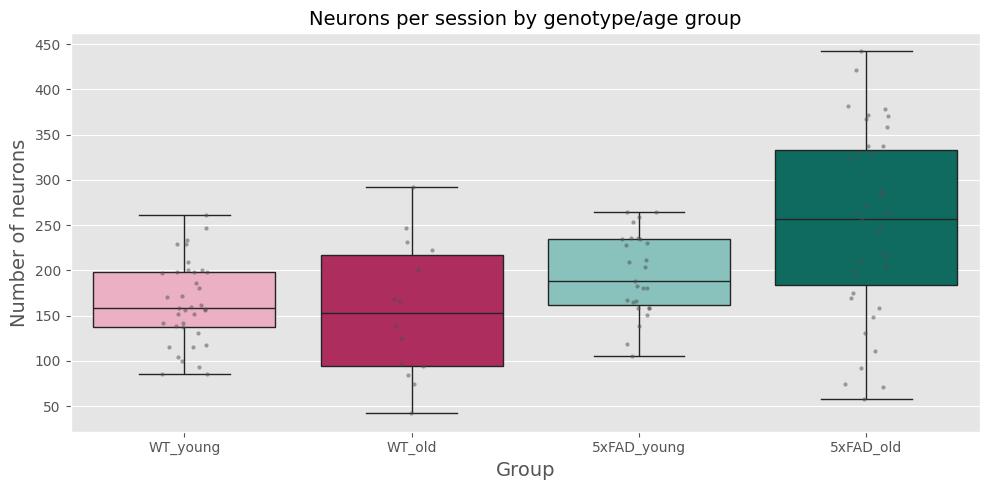

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
group_order = ["WT_young", "WT_old", "5xFAD_young", "5xFAD_old"]
palette = {
    g: mice.get_colors_genotype_age(*g.split("_")) for g in group_order
}
sns.boxplot(
    data=df_neurons, x="Group", y="N_neurons",
    order=group_order, palette=palette, ax=ax,
)
sns.stripplot(
    data=df_neurons, x="Group", y="N_neurons",
    order=group_order, color=".3", size=3, ax=ax, alpha=0.5,
)
ax.set_ylabel("Number of neurons")
ax.set_title("Neurons per session by genotype/age group")
plt.tight_layout()
plt.show()

## 4. Session-type counts

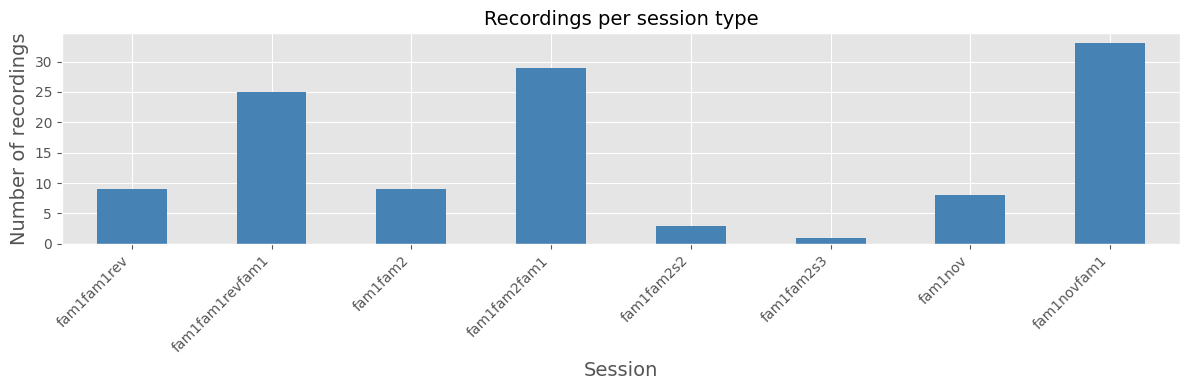

In [16]:
session_counts = df_neurons["Session"].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(12, 4))
session_counts.plot.bar(ax=ax, color="steelblue")
ax.set_ylabel("Number of recordings")
ax.set_title("Recordings per session type")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 5. Data-availability heatmap

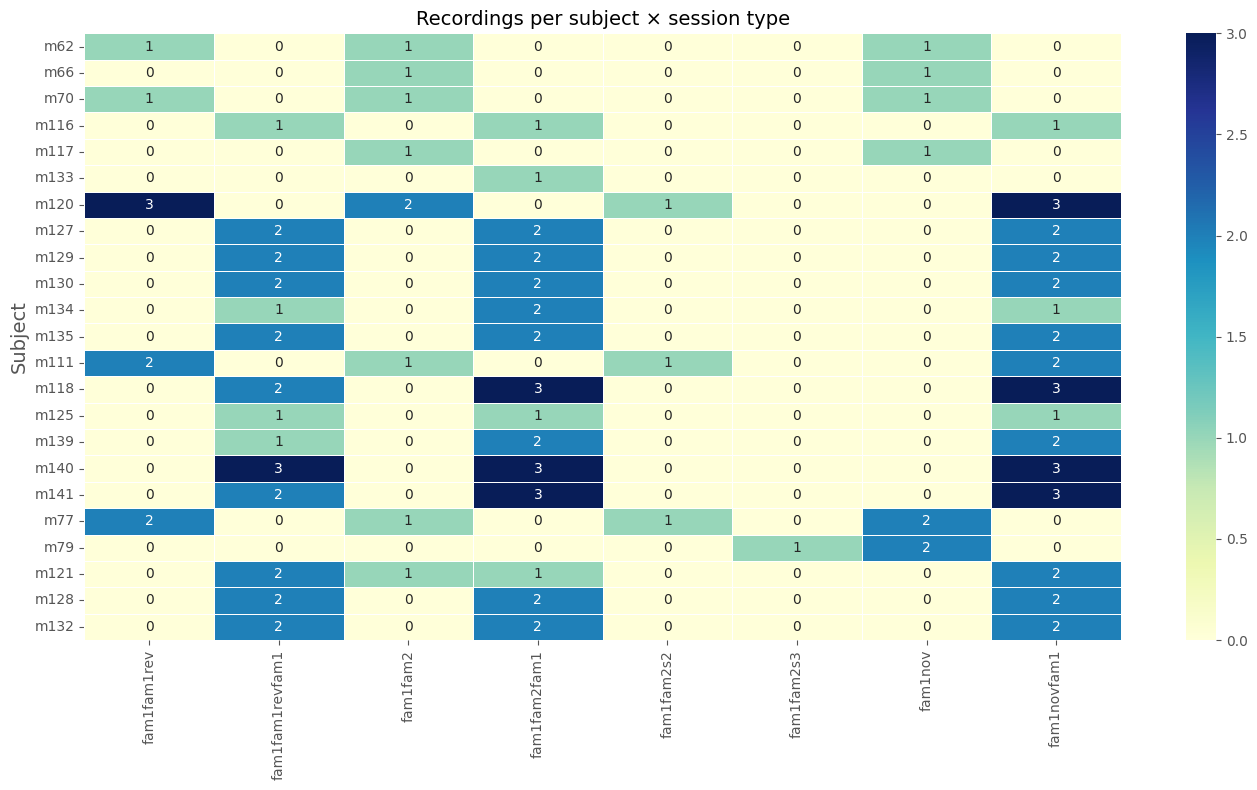

In [17]:
# Build a subject × session-type availability matrix
all_sessions = sorted(df_neurons["Session"].unique())
all_subjects = [s.value for s in mice.get_all_subjects()]

avail = pd.DataFrame(0, index=all_subjects, columns=all_sessions)
for _, row in df_neurons.iterrows():
    avail.loc[row["Subject"], row["Session"]] += 1

fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(avail, cmap="YlGnBu", annot=True, fmt="d", linewidths=0.5, ax=ax)
ax.set_title("Recordings per subject × session type")
ax.set_ylabel("Subject")
plt.tight_layout()
plt.show()

## 6. Session duration distribution

In [18]:
duration_rows = []
for subject in mice.get_all_subjects():
    info = mice.get_subject_info(subject)
    fovs = mice.get_available_fovs(subject)
    for fov in fovs:
        for session in mice.get_available_sessions(subject, fov):
            for run in mice.get_available_runs(subject, fov, session):
                df = mice.load_data(subject, fov, session, run)
                if "glob_time" in df.columns:
                    dur = df["glob_time"].iloc[-1] - df["glob_time"].iloc[0]
                    duration_rows.append({
                        "Subject": subject.value,
                        "Group": f"{info['genotype']}_{info['age']}",
                        "Session": session,
                        "Run": run,
                        "Duration_s": dur,
                    })

df_dur = pd.DataFrame(duration_rows)
print(f"Total runs: {len(df_dur)}")
df_dur.describe()

Total runs: 321


,Duration_s
count,321.000000
mean,1093.792961
std,541.956125
min,240.097087
25%,720.355987
50%,960.485437
75%,1440.711974
max,3121.650485


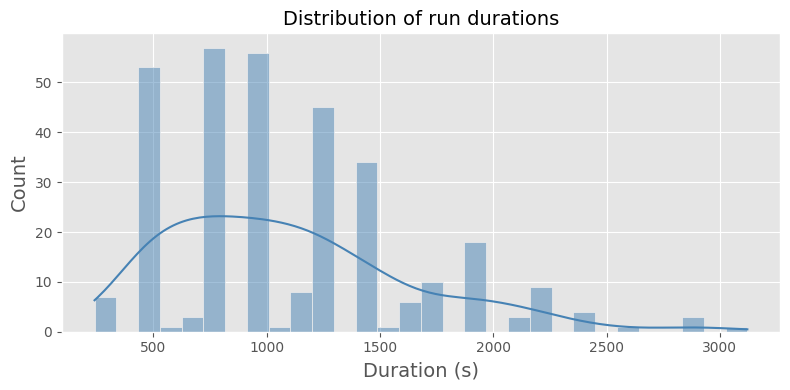

In [19]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(df_dur["Duration_s"], bins=30, kde=True, ax=ax, color="steelblue")
ax.set_xlabel("Duration (s)")
ax.set_title("Distribution of run durations")
plt.tight_layout()
plt.show()

## 7. Total recording time per group

/var/folders/rx/pf6l4dhd4510k3rc8877hjwm0000gn/T/ipykernel_11589/2850276748.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


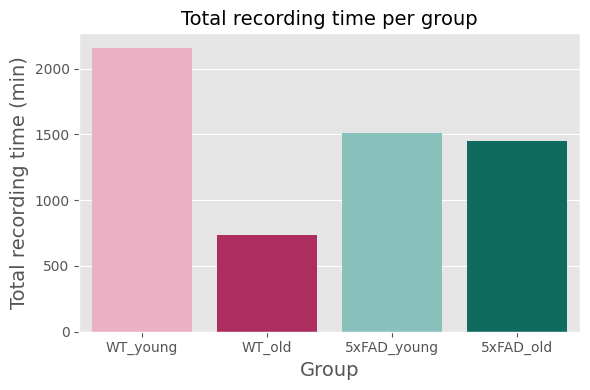

In [20]:
group_dur = df_dur.groupby("Group")["Duration_s"].sum().reset_index()
group_dur["Duration_min"] = group_dur["Duration_s"] / 60

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(
    data=group_dur, x="Group", y="Duration_min",
    order=["WT_young", "WT_old", "5xFAD_young", "5xFAD_old"],
    palette=palette, ax=ax,
)
ax.set_ylabel("Total recording time (min)")
ax.set_title("Total recording time per group")
plt.tight_layout()
plt.show()